## CIFAR-10 Data Preprocessing for Hopfield Networks and Phase Space Learning

### Step 1: Install and Import Required Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# import models
from hopfield_PSL import HopfieldPSL
# from hopfield_baseline import HopfieldRNN
# from storkey import HopfieldRNNStorkey

### Step 2: Load the CIFAR-10 Dataset

In [2]:
# defining a transform for converting images to grayscale and tensors
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
color_trainset = datasets.CIFAR10(root='./data', train=True, download=True)

print(f'Training set size: {len(train_dataset)}')

Training set size: 50000


### Step 3: Binarize the Images to -1/+1

In [3]:
# convert images to numpy arrays
train_images = torch.stack([img for img,_ in train_dataset]).numpy()

# binarize the images
train_images = np.where(train_images > 0.5, 1, -1)

# verify the range of values
print(f'Unique pixel values after binarization: {np.unique(train_images)}')

Unique pixel values after binarization: [-1  1]


### Step 4: Reshape Images into 1024-bit Vectors

In [4]:
train_images = train_images.reshape(len(train_images), -1)

### Step 6: Visualize Some Binarized Images

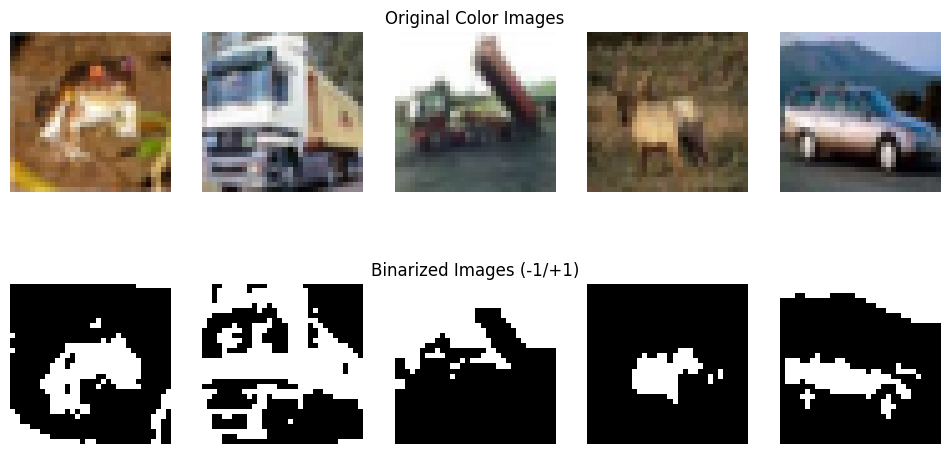

In [5]:
num_images = 5
fig, axes = plt.subplots(2,num_images,figsize=(12,6))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot binarized grayscale images
    axes[1,i].imshow(train_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Binarized Images (-1/+1)', fontsize=12, loc='center')

plt.show()

### Step 7: Generate a Corrupted Subset of Training Images

In [6]:
def corrupt_images(images, corruption_type="mask ", corruption_fraction=0.25):
    """
    Corrupt images by either masking pixels or flipping them

    Args:
        images (numpy array): binarized images to corrupt
        corruption_type (str): "mask" to set pixels to 0, "flip" to invert pixels
        corruption_fraction (float): Fraction of pixels to corrupt

    Returns:
        numpy array: Corrupted images
    """
    corrupted_images = images.copy()
    num_pixels = images.shape[1]
    num_corrupt = int(corruption_fraction * num_pixels)

    for img in corrupted_images:
        corrupt_indices = np.random.choice(num_pixels, num_corrupt, replace=False)

        if corruption_type == 'mask':
            img[corrupt_indices] = 0
        elif corruption_type == 'flip':
            img[corrupt_indices] *= -1
    return corrupted_images

In [7]:
# create corrupted images to use as test set
masked_images = corrupt_images(train_images, corruption_type='mask', corruption_fraction=0.25)
flipped_images = corrupt_images(train_images, corruption_type='flip', corruption_fraction=0.25)

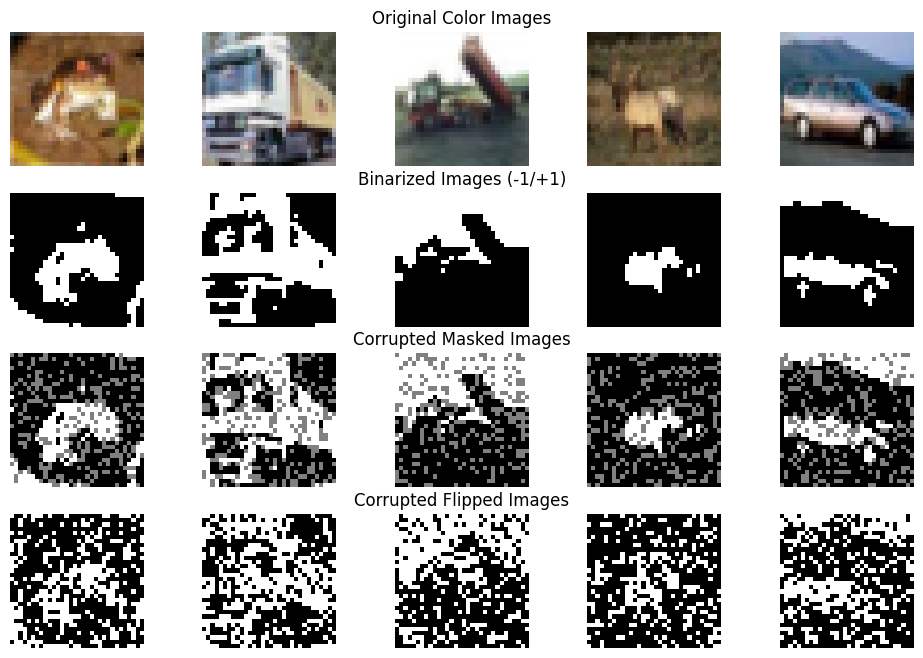

In [8]:
# Visualize some corrupted images

num_images = 5
fig, axes = plt.subplots(4,num_images,figsize=(12,8))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot binarized grayscale images
    axes[1,i].imshow(train_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

    # Plot corrupted masked images
    axes[2,i].imshow(masked_images[i].reshape(32,32), cmap='gray')
    axes[2,i].axis('off')

    # Plot corrupted flipped images
    axes[3,i].imshow(flipped_images[i].reshape(32,32), cmap='gray')
    axes[3,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Binarized Images (-1/+1)', fontsize=12, loc='center')
axes[2,num_images//2].set_title('Corrupted Masked Images', fontsize=12, loc='center')
axes[3,num_images//2].set_title('Corrupted Flipped Images', fontsize=12, loc='center')


plt.show()

### Step 8: Save the Preprocessed Datasets

In [9]:
# Create 'data/binarized' directory if it doesn't exist
if not os.path.isdir('data/binarized'):
    os.mkdir('data/binarized')

np.save("data/binarized/train_images.npy", train_images)
np.save("data/binarized/masked_images.npy", masked_images)
np.save("data/binarized/flipped_images.npy", flipped_images)


In [10]:
len(train_images)

50000

### Training

In [128]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

In [161]:
num_neurons = 1024
num_patterns = 50
epochs = 25
lr = 0.0001
model = HopfieldPSL()

optimizer = optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.MSELoss()
# criterion = 

idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)
original = [stored_images[i] for i in idxs]
corrupted = [masked_images[i] for i in idxs]
targets = [tensor * 0.9 for tensor in original]

In [162]:
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for i in range(len(original)):
        optimizer.zero_grad()          # Clear gradients
        output = model(original[i])          # Forward pass
        loss = 0

        for state in output: # Compute reconstruction loss
            loss += criterion(state, targets[i])
        #loss = criterion(output, targets[i])  # Compute reconstruction loss
        
        loss.backward()                  # Backpropagation
        optimizer.step()                 # Update weights
        
        total_loss += loss.item()
    avg_loss = total_loss / len(original)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

Epoch [1/25], Loss: 3.919021
Epoch [2/25], Loss: 2.692235
Epoch [3/25], Loss: 2.270234
Epoch [4/25], Loss: 1.975809
Epoch [5/25], Loss: 1.754928
Epoch [6/25], Loss: 1.581723
Epoch [7/25], Loss: 1.451392
Epoch [8/25], Loss: 1.348145
Epoch [9/25], Loss: 1.257294
Epoch [10/25], Loss: 1.205864
Epoch [11/25], Loss: 1.134569
Epoch [12/25], Loss: 1.084858
Epoch [13/25], Loss: 1.045986
Epoch [14/25], Loss: 0.999168
Epoch [15/25], Loss: 0.950607
Epoch [16/25], Loss: 0.917323
Epoch [17/25], Loss: 0.862478
Epoch [18/25], Loss: 0.837621
Epoch [19/25], Loss: 0.815018
Epoch [20/25], Loss: 0.767318
Epoch [21/25], Loss: 0.755712
Epoch [22/25], Loss: 0.698737
Epoch [23/25], Loss: 0.680732
Epoch [24/25], Loss: 0.617288
Epoch [25/25], Loss: 0.593178


In [163]:
#retrieved = [torch.sign(model(model(model(model(img))))).detach().numpy() for img in corrupted]
retrieved = [model.retrieve_pattern(img).detach().numpy() for img in corrupted]

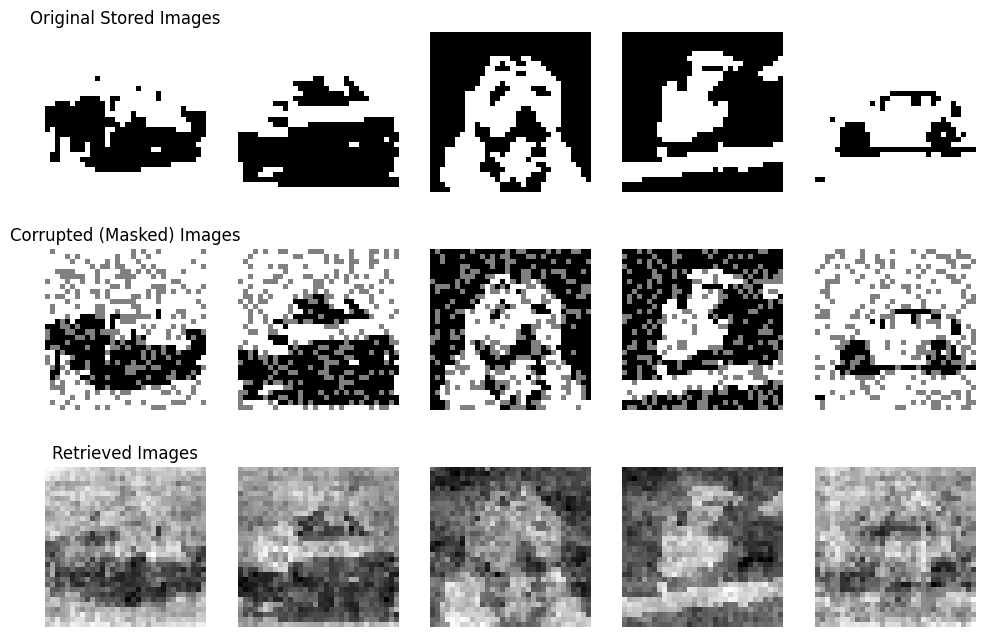

In [164]:
import matplotlib.pyplot as plt

def plot_comparisons(original, corrupted, retrieved, title_corrupted, title_retrieved, num_samples=5):

    fig, axes = plt.subplots(3, num_samples, figsize=(12, 8))

    for i in range(num_samples):
        # Original stored image
        axes[0, i].imshow(original[i].reshape(32, 32), cmap='gray')
        axes[0, i].axis('off')

        # Corrupted image
        axes[1, i].imshow(corrupted[i].reshape(32, 32), cmap='gray')
        axes[1, i].axis('off')

        # Retrieved image
        axes[2, i].imshow(retrieved[i].reshape(32, 32), cmap='gray')
        axes[2, i].axis('off')

    # Add row titles
    axes[0, 0].set_title("Original Stored Images", fontsize=12, loc='center')
    axes[1, 0].set_title(title_corrupted, fontsize=12, loc='center')
    axes[2, 0].set_title(title_retrieved, fontsize=12, loc='center')

    plt.show()

# Plot results for masked images
plot_comparisons(original, corrupted, retrieved, "Corrupted (Masked) Images", "Retrieved Images")

# plot_comparisons(stored_images.numpy()[idxs], masked_images.numpy()[idxs], retrieved_masked.detach().numpy(),
#                  "Corrupted (Masked) Images", "Retrieved Images")

# # Plot results for flipped images
# plot_comparisons(stored_images.numpy()[idxs], flipped_images.numpy()[idxs], retrieved_flipped.detach().numpy(),
#                  "Corrupted (Flipped) Images", "Retrieved Images")
